In [6]:
from itertools import combinations
import numpy as np
import scipy.optimize as opt
import tifffile as tf
import matplotlib.pyplot as plt

def interploate_E(refs, e):
    n = np.shape(refs)[1]
    refs = np.array(refs)
    ref_e = refs[:, 0]
    ref = refs[:, 1:n]
    all_ref = []
    for i in range(n - 1):
        ref_i = np.interp(e, ref_e, ref[:, i])
        all_ref.append(ref_i)
    return np.array(all_ref)

In [7]:
img_stack = tf.imread(r'C:\Users\pattammattel\Desktop\MIDAS_Admin\sample_data\Site4um.tiff')
e_list = np.loadtxt(r'C:\Users\pattammattel\Desktop\MIDAS_Admin\sample_data\Site4um.txt')
refs = np.loadtxt(r'C:\Users\pattammattel\Desktop\MIDAS_Admin\sample_data\test_ref_athena.nor')

In [8]:
sample_spec = img_stack.mean(1).mean(1)
int_refs = interploate_E(refs, e_list)
coeffs, r = opt.nnls(int_refs.T, sample_spec)


In [9]:
for i in range(int_refs.shape[0]):
    if not i==0:
        ref = np.column_stack([e_list,int_refs[i]])
        
        

In [11]:
ll = ['ll','jj','kk','pp']
list(list(combinations(ll,2))[0])

['ll', 'jj']

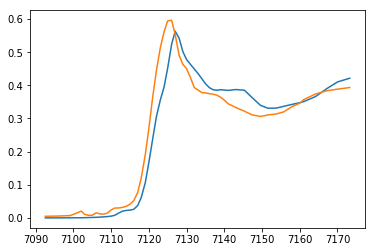

In [12]:
plt.plot(e_list,  (np.dot(coeffs,int_refs)))
plt.plot(e_list, sample_spec)


In [16]:
def interploate_E(refs, e):
    n = np.shape(refs)[1]
    refs = np.array(refs)
    ref_e = refs[:, 0]
    ref = refs[:, 1:n]
    all_ref = []
    for i in range(n - 1):
        ref_i = np.interp(e, ref_e, ref[:, i])
        all_ref.append(ref_i)
    return np.array(all_ref)

new_ref = interploate_E(refs, e_list)

In [32]:
from sklearn import linear_model 

def xanes_fitting(im_stack, e_list, refs, method='NNLS'):
    """Linear combination fit of image data with reference standards"""
    en,im1,im2 = np.shape(im_stack)

    int_refs = (interploate_E(refs, e_list))
    im_array = im_stack.reshape(en, im1*im2)

    if method == 'NNLS':
        
        coeffs_arr = []
        r_factor_arr = []
        
        for i in range(im1*im2):
            coeffs, r = opt.nnls(int_refs.T, im_array[:,i])
            coeffs_arr.append(coeffs)
            r_factor_arr.append(r)
            
        abundance_map = np.reshape(coeffs_arr,(im1,im2,-1))
        r_factor = np.reshape(r_factor_arr,(im1,im2))
        
        
    elif method == 'LASSO':

        coeffs_arr = []
        r_factor_arr = []
        reg = linear_model.Lasso(positive=True, alpha=0.08)
        for i in range(im1 * im2):
            fit_results = reg.fit(int_refs.T, im_array[:, i])
            r = fit_results.score(int_refs.T, im_array[:, i])
            coeffs_arr.append(fit_results.coef_)
            r_factor_arr.append(r)

        abundance_map = np.reshape(coeffs_arr, (im1, im2, -1))
        r_factor = np.reshape(r_factor_arr, (im1, im2))

    return abundance_map,r_factor

In [33]:
mp,rf = xanes_fitting(img_stack, e_list, refs, method='LASSO')

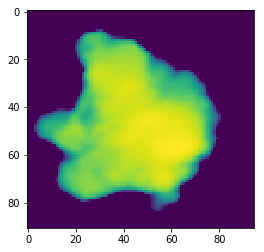

In [41]:
plt.imshow(rf)